# Advanced Lane Lines Detection: Self Driving Cars Project 4
### Author: David Escolme
### Date: March 2018
A notebook showing the application of techniques for advanced lane detection

In [2]:
# imports
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [ ]:
"""
detector = lane_detector()
detector.output_type = None
white_output = 'test_videos_output/solidWhiteRightFINAL.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
"""

## Section 1: Camera Calibration

In [2]:
# calibration images
IMG_DIR = 'camera_cal/'
calibration_files = glob.glob(IMG_DIR+"*.jpg")

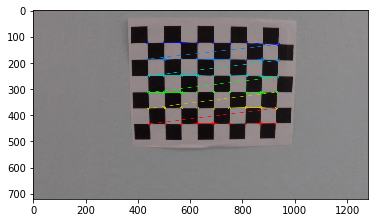

In [3]:
# try 1 image
img = cv2.imread(calibration_files[9])
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (9, 6), corners, ret)
    plt.imshow(img)

In [4]:
# let's now try to get the image correction params across all images
objpoints = []
imgpoints = []
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
for img in calibration_files:
    img = cv2.imread(img)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

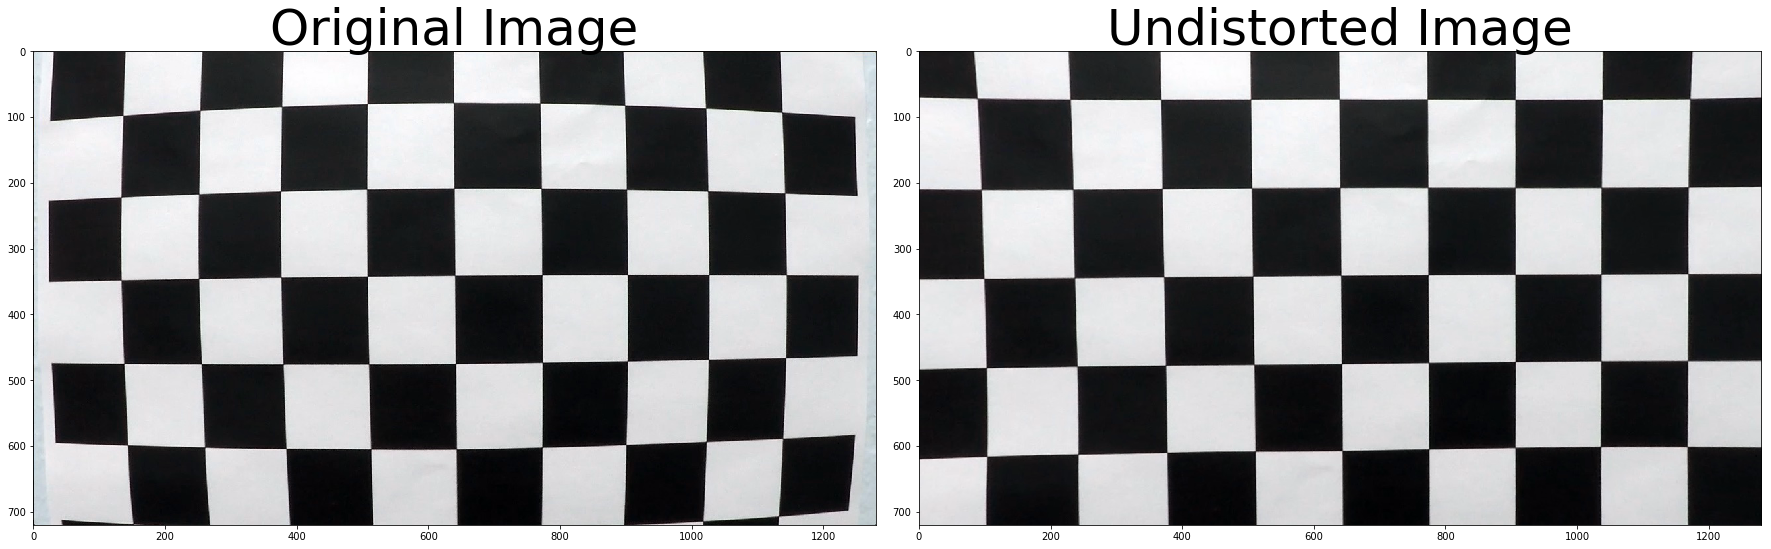

In [5]:
# now we have the image and object points:
img = cv2.imread(calibration_files[0])

# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Section 2: Static Image Pipeline
Here we build a pipeline that can be used to detect lane lines. The code above has calibrated the camera and we can use: `def cal_undistort(img, objpoints, imgpoints):` as the first stage of the pipeline. This requires that the code cells above have been run before the following cells.

In [6]:
# let's get a list of static test images
IMG_DIR = 'test_images/'
calibration_files = glob.glob(IMG_DIR+"*.jpg")

In [7]:
# printer helper function
def print_images(img1, img1_title, img2, img2_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax1.set_title(img1_title, fontsize=50)
    ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax2.set_title(img2_title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

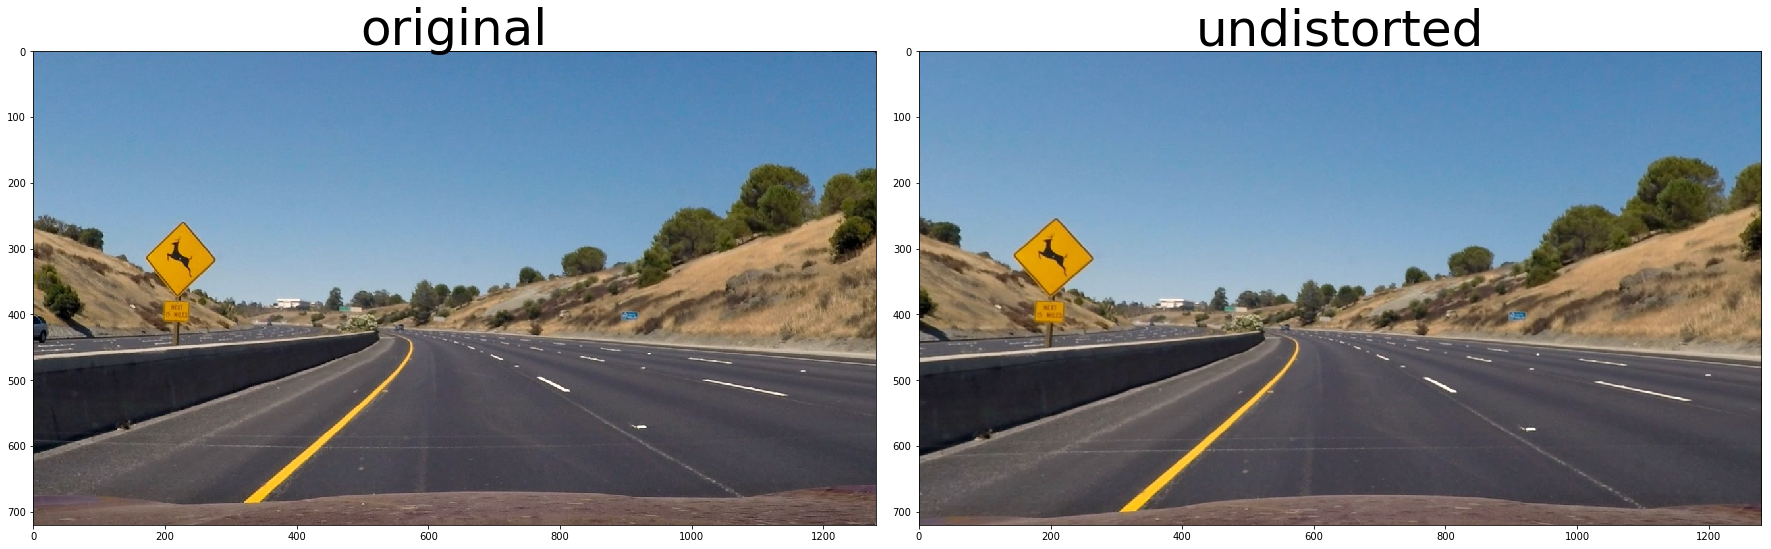

In [8]:
# the pipeline - using 1 image:
img = cv2.imread(calibration_files[3])
# pipeline 1: undistort
undistorted = cal_undistort(img, objpoints, imgpoints)
print_images(img,'original',undistorted,'undistorted')

In [30]:
# perspective transform
def apply_perspective_transform(img):
    # get image size
    img_size = (img.shape[1], img.shape[0])
    
    # coordinates
    src = np.float32([[675,450],[1100,680],[325,680],[575,450]])
    dst = np.float32([[700,150],[700,680],[450,680],[450,150]])
    
    # get transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

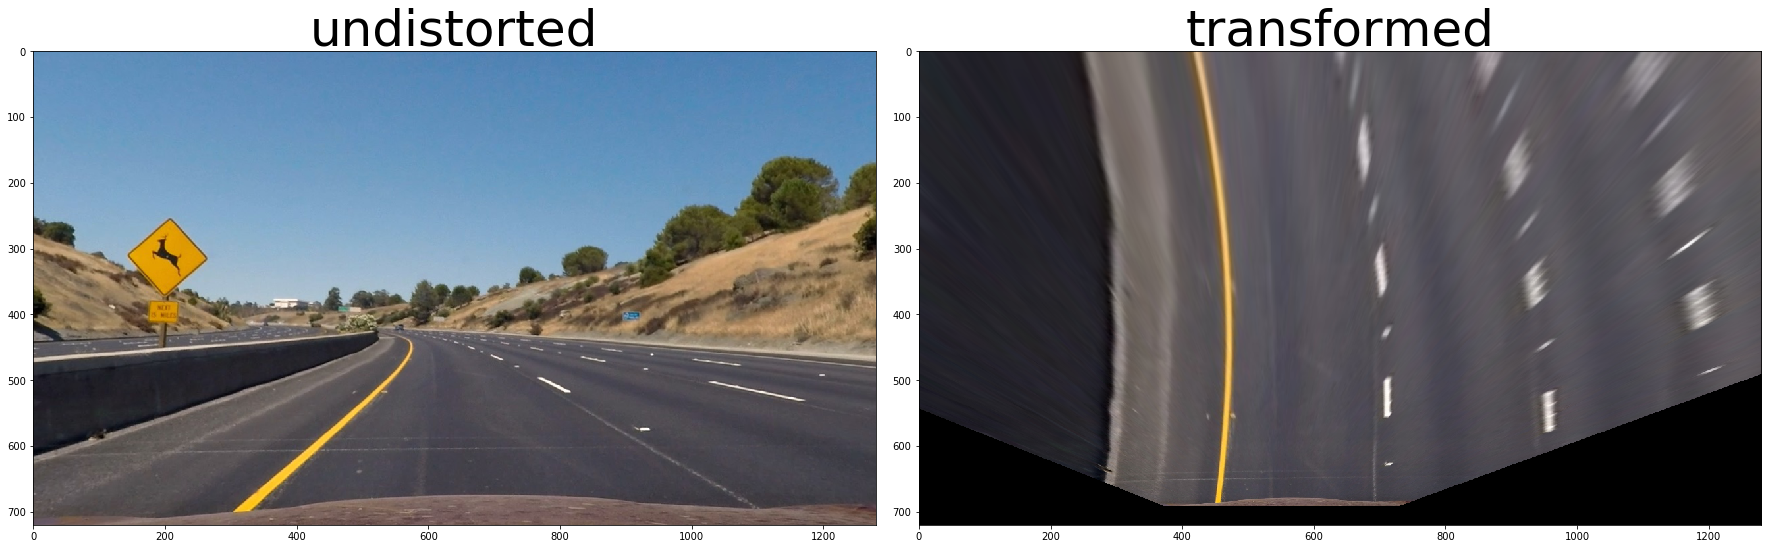

In [31]:
transformed = apply_perspective_transform(undistorted)
print_images(undistorted,'undistorted',transformed,'transformed')

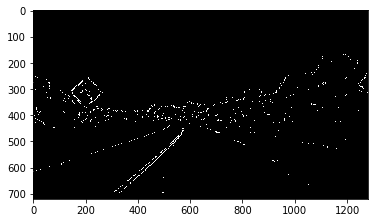

In [11]:
# now do thresholding...
img = cv2.imread(calibration_files[3])
def sobel_thresh_abs(img, orient='x', thresh=(50,100)):
    # get grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # do sobel
    if orient == 'x':
        sobelv = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobelv = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # abs
    abs_sobel = np.absolute(sobelv)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # now threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

plt.imshow(sobel_thresh_abs(undistorted, 'x'), cmap='gray')

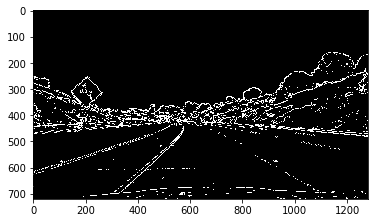

In [12]:
def sobel_thresh_mag(img, sobel_kernel=3, thresh=(0, 255)):
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    # scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # create a binary mask where mag thresholds are met
    sxybinary = np.zeros_like(scaled_sobel)
    sxybinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # return this mask as your binary_output image
    return sxybinary
plt.imshow(sobel_thresh_mag(undistorted, 3, (30, 100)), cmap='gray')

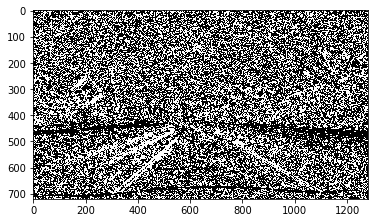

In [13]:
def sobel_thresh_dir(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # return this mask as your binary_output image
    return sbinary
plt.imshow(sobel_thresh_dir(undistorted, 15, (0.7, 1.3)), cmap='gray')

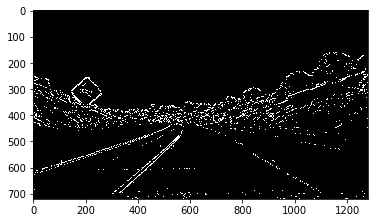

In [14]:
# let's try a combined example
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = sobel_thresh_abs(undistorted, 'x', thresh=(25, 110))
grady = sobel_thresh_abs(undistorted, 'y', thresh=(25, 110))
mag_binary = sobel_thresh_mag(undistorted, ksize, thresh=(25, 110))
dir_binary = sobel_thresh_dir(undistorted, ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.imshow(combined, cmap='gray')

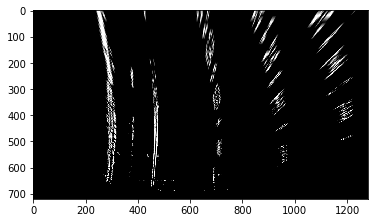

In [32]:
transformed = apply_perspective_transform(combined)
plt.imshow(transformed, cmap='gray')

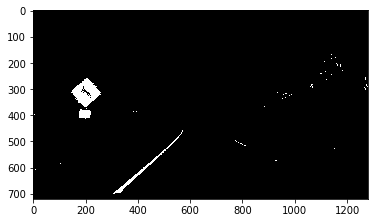

In [16]:
def hls_select(img, thresh=(0, 255)):
    # convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # apply a threshold to the S channel
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # return a binary image of threshold result
    return binary_output

hls_image = hls_select(undistorted, thresh=(180,255))
plt.imshow(hls_image, cmap='gray')

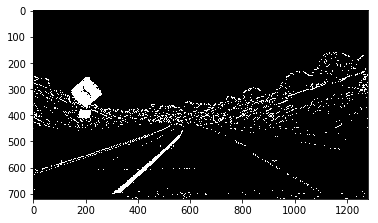

In [17]:
combined_binary = np.zeros_like(combined)
combined_binary[(combined == 1) | (hls_image == 1)] = 1
plt.imshow(combined_binary, cmap='gray')

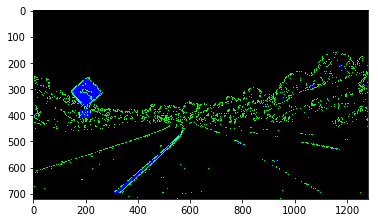

In [18]:
color_binary = np.dstack(( np.zeros_like(gradx), gradx, hls_image)) * 255
plt.imshow(color_binary)

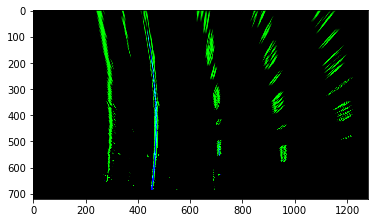

In [33]:
transformed = apply_perspective_transform(color_binary)
plt.imshow(transformed, cmap='gray')

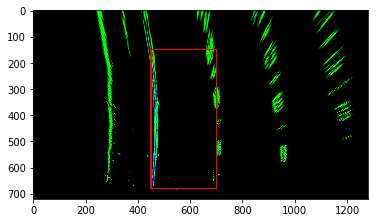

In [20]:
tx = transformed.copy()
un = undistorted.copy()
cv2.line(tx, (700,150), (700,680), color=(255,0,0), thickness=3) 
cv2.line(tx, (700,680), (450, 680), color=(255,0,0), thickness=3) 
cv2.line(tx, (450, 680), (450, 150), color=(255,0,0), thickness=3) 
cv2.line(tx, (450, 150), (700, 150), color=(255,0,0), thickness=3) 
plt.imshow(tx, cmap='gray')

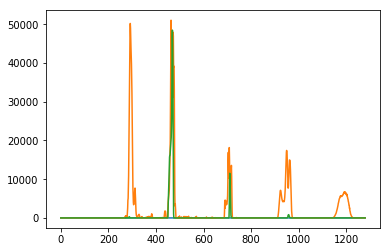

In [21]:
# find the histogram
cb_transformed = apply_perspective_transform(color_binary)
histogram = np.sum(cb_transformed[cb_transformed.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [24]:
out_img = cb_transformed.copy()
# find peaks
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(cb_transformed.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = cb_transformed.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = int(leftx_base / 2)
rightx_current = int(rightx_base / 2)
print(leftx_current, rightx_current)
# Set the width of the windows +/- margin
margin = 80
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = cb_transformed.shape[0] - (window+1)*window_height
    win_y_high = cb_transformed.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

695 422


(720, 0)

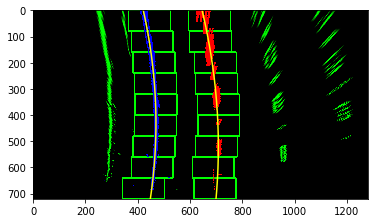

In [25]:
# Generate x and y values for plotting
ploty = np.linspace(0, cb_transformed.shape[0]-1, cb_transformed.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [36]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = cb_transformed.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, cb_transformed.shape[0]-1, cb_transformed.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

In [38]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((cb_transformed, cb_transformed, cb_transformed)*255)
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (11640,2295)

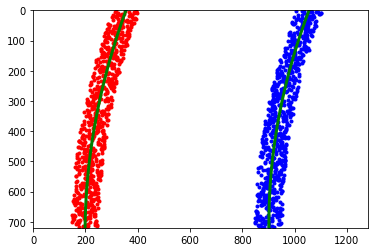

In [39]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [40]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1755.71059977 1612.00852821


In [41]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

576.535943386 m 529.390269481 m
